# The Problem Statement:

The sequence identity of the COVID19 protease and that of SARS-CoV is high, hence by using the known SARS-CoV protease drugs generate possible drugs using machine learning methods to generate novel drug like candidates. Use a variational autoencoder with SMILES representation to generate novel molecules from the trained continuous latent space. The novel molecules shall be assessed based on SMART pattern matching, to rule out unlikely molecular structures e.g structures with multiple 3,4,7,8 membered rings, purely acyclic compounds, highly branched ones etc. Furthermore, diversity based on PubChem / MACCS fingerprints (tanimoto coefficients <= 0.60) shall also be assessed to make sure generated structures are significantly dissimilar to training set. Use multiple SARS-CoV-2 protease conformation to screen of generated chemicals using ensemble molecular docking protocol at both allosteric and orthosteric sites. Retain chemicals with best docking scores and binding energies as per the guidelines. Shortlist the top 100 or top 25% (max 100) hits and refine the best 10 using MD simulation without any restraints.

In [1]:
import pandas as pd
import numpy as np
import random

In [2]:
random.seed(24)

In [3]:
from rdkit import Chem, DataStructs
from rdkit.Chem import Draw, Descriptors, AllChem

def canonicalize(smiles):
    return Chem.MolToSmiles(Chem.MolFromSmiles(smiles))

def validSMILES(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return False
    return True

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef
from sklearn.cluster import KMeans

In [101]:
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.nn.utils.rnn import pad_packed_sequence, pack_padded_sequence#, masked_cross_entropy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [105]:
USE_CUDA = torch.cuda.is_available() #False on my computer argh

In [9]:
traindata = pd.read_csv('data/trainDILI.csv')

In [10]:
traindata['SMILES']

0                                        BrC(Cl)C(F)(F)F
1                            Br[C@@H](C(C)C)C(=O)NC(=O)N
2      Brc1[nH]c2c3c1CC1N(CC(C=C1c3ccc2)C(=O)N[C@]1(O...
3        Brc1c(nc(nc1Oc1c(cc(cc1C)C#N)C)Nc1ccc(cc1)C#N)N
4                             Brc1c2nccnc2ccc1NC=1NCCN=1
                             ...                        
961                           s1cccc1CN(CCN(C)C)c1ncccc1
962    s1cccc1C\C(=C/c1n(Cc2ccc(cc2)C(O)=O)c(nc1)CCCC...
963                               s1cccc1\C=C\C1=NCCCN1C
964          s1ccnc1NC(=O)C=1N(S(=O)(=O)c2c(cccc2)C=1O)C
965    s1cncc1COC(=O)NC(Cc1ccccc1)C(O)CC(NC(=O)C(NC(=...
Name: SMILES, Length: 966, dtype: object

In [11]:
traindata['cleanSMILES'] = traindata['SMILES'].apply(canonicalize)

In [12]:
traindata

,SMILES,Drug_Name,IsDILI,cleanSMILES
0,BrC(Cl)C(F)(F)F,Halothane,1.0,FC(F)(F)C(Cl)Br
1,Br[C@@H](C(C)C)C(=O)NC(=O)N,Bromisoval,1.0,CC(C)[C@H](Br)C(=O)NC(N)=O
2,Brc1[nH]c2c3c1CC1N(CC(C=C1c3ccc2)C(=O)N[C@]1(O...,Bromocriptine,0.0,CC(C)CC1C(=O)N2CCCC2[C@@]2(O)O[C@@](NC(=O)C3C=...
3,Brc1c(nc(nc1Oc1c(cc(cc1C)C#N)C)Nc1ccc(cc1)C#N)N,Etravirine,1.0,Cc1cc(C#N)cc(C)c1Oc1nc(Nc2ccc(C#N)cc2)nc(N)c1Br
4,Brc1c2nccnc2ccc1NC=1NCCN=1,Brimonidine,0.0,Brc1c(NC2=NCCN2)ccc2nccnc12
...,...,...,...,...
961,s1cccc1CN(CCN(C)C)c1ncccc1,Methapyrilene,1.0,CN(C)CCN(Cc1cccs1)c1ccccn1
962,s1cccc1C\C(=C/c1n(Cc2ccc(cc2)C(O)=O)c(nc1)CCCC...,Eprosartan,0.0,CCCCc1ncc(/C=C(\Cc2cccs2)C(=O)O)n1Cc1ccc(C(=O)...
963,s1cccc1\C=C\C1=NCCCN1C,Pyrantel,0.0,CN1CCCN=C1/C=C/c1cccs1
964,s1ccnc1NC(=O)C=1N(S(=O)(=O)c2c(cccc2)C=1O)C,Sudoxicam,1.0,CN1C(C(=O)Nc2nccs2)=C(O)c2ccccc2S1(=O)=O


In [13]:
data = list(zip(traindata['SMILES'],traindata['cleanSMILES']))
identitydata = list(zip(traindata['cleanSMILES'],traindata['cleanSMILES']))

In [14]:
identitydata

[('FC(F)(F)C(Cl)Br', 'FC(F)(F)C(Cl)Br'),
 ('CC(C)[C@H](Br)C(=O)NC(N)=O', 'CC(C)[C@H](Br)C(=O)NC(N)=O'),
 ('CC(C)CC1C(=O)N2CCCC2[C@@]2(O)O[C@@](NC(=O)C3C=C4c5cccc6[nH]c(Br)c(c56)CC4N(C)C3)(C(C)C)C(=O)N12',
  'CC(C)CC1C(=O)N2CCCC2[C@@]2(O)O[C@@](NC(=O)C3C=C4c5cccc6[nH]c(Br)c(c56)CC4N(C)C3)(C(C)C)C(=O)N12'),
 ('Cc1cc(C#N)cc(C)c1Oc1nc(Nc2ccc(C#N)cc2)nc(N)c1Br',
  'Cc1cc(C#N)cc(C)c1Oc1nc(Nc2ccc(C#N)cc2)nc(N)c1Br'),
 ('Brc1c(NC2=NCCN2)ccc2nccnc12', 'Brc1c(NC2=NCCN2)ccc2nccnc12'),
 ('Cn1cnc2c(F)c(Nc3ccc(Br)cc3Cl)c(C(=O)NOCCO)cc21',
  'Cn1cnc2c(F)c(Nc3ccc(Br)cc3Cl)c(C(=O)NOCCO)cc21'),
 ('CCc1oc2ccccc2c1C(=O)c1cc(Br)c(O)c(Br)c1',
  'CCc1oc2ccccc2c1C(=O)c1cc(Br)c(O)c(Br)c1'),
 ('NC(N)=Nc1nc(CSCC/N=C/NS(=O)(=O)c2ccc(Br)cc2)cs1',
  'NC(N)=Nc1nc(CSCC/N=C/NS(=O)(=O)c2ccc(Br)cc2)cs1'),
 ('Nc1c(CC(=O)O)cccc1C(=O)c1ccc(Br)cc1',
  'Nc1c(CC(=O)O)cccc1C(=O)c1ccc(Br)cc1'),
 ('CN(C)CCC(c1ccc(Br)cc1)c1ccccn1', 'CN(C)CCC(c1ccc(Br)cc1)c1ccccn1'),
 ('Brc1ccccc1', 'Brc1ccccc1'),
 ('CCCC1CC(C(=O)NC(C(C)Cl)C2OC(SC

We clean up the similes strings into stuff that can be fed into the LSTM
#use content from https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html

In [18]:
PAD_token = 0
SOS_token = 1
EOS_token = 2

class Lang:
    def __init__(self, name):
        self.name = name
        self.char2index = {}
        self.char2count = {}
        self.index2char = {0: "PAD", 1: "SOS", 2: "EOS"}
        self.n_chars = 3  # Count SOS and EOS and PAD

    def addSMILES(self, smiles):
        for char in smiles:
            self.addChar(char)

    def addChar(self, char):
        if char not in self.char2index:
            self.char2index[char] = self.n_chars
            self.char2count[char] = 1
            self.index2char[self.n_chars] = char
            self.n_chars += 1
        else:
            self.char2count[char] += 1

max([len(smiles) for smiles in traindata['SMILES'] ]) = 297

max([len(smiles) for smiles in traindata['cleanSMILES'] ]) = 293

In [19]:
MIN_LENGTH = 3
MAX_LENGTH = 25

def filter_pairs(pairs):
    filtered_pairs = []
    for pair in pairs:
        if len(pair[0]) >= MIN_LENGTH and len(pair[0]) <= MAX_LENGTH \
            and len(pair[1]) >= MIN_LENGTH and len(pair[1]) <= MAX_LENGTH:
                filtered_pairs.append(pair)
    return filtered_pairs

In [20]:
def prepareData(lang1, lang2, data):
    """takes data as list of pairs for now
    returns the dictionaries for input and output languages, and the pairs"""
    input_lang = Lang(lang1)
    output_lang = Lang(lang2)
    pairs = data
    print("Read %s smiles pairs" % len(pairs))
    
    pairs = filter_pairs(pairs)
    print("Filtered to %d pairs" % len(pairs))
    
    print("Counting chars...")
    for pair in pairs:
        input_lang.addSMILES(pair[0])
        output_lang.addSMILES(pair[1])
    print("Counted chars:")
    print(input_lang.name, input_lang.n_chars)
    print(output_lang.name, output_lang.n_chars)
    return input_lang, output_lang, pairs

In [236]:
input_lang, output_lang, pairs = prepareData("Random SMILES","Canonical SMILES", data)
#input_lang, output_lang, pairs = prepareData("Canonical SMILES","Canonical SMILES", identitydata)
print(random.choice(pairs))

Read 966 smiles pairs
Filtered to 137 pairs
Counting chars...
Counted chars:
Random SMILES 29
Canonical SMILES 30
('N(CCN1CCCCCCC1)C(N)=N', 'N=C(N)NCCN1CCCCCCC1')


In [237]:
pairs

[('BrC(Cl)C(F)(F)F', 'FC(F)(F)C(Cl)Br'),
 ('Brc1ccccc1', 'Brc1ccccc1'),
 ('ClC(Cl)C(F)(F)OC', 'COC(F)(F)C(Cl)Cl'),
 ('ClC(F)C(F)(F)OC(F)F', 'FC(F)OC(F)(F)C(F)Cl'),
 ('ClC(OC(F)F)C(F)(F)F', 'FC(F)OC(Cl)C(F)(F)F'),
 ('ClC1=NOC(C1)C(N)C(O)=O', 'NC(C(=O)O)C1CC(Cl)=NO1'),
 ('ClCCN(CCCl)C', 'CN(CCCl)CCCl'),
 ('ClCCN(N=O)C(=O)NC1CCCCC1', 'O=NN(CCCl)C(=O)NC1CCCCC1'),
 ('ClCCN(N=O)C(=O)NCCCl', 'O=NN(CCCl)C(=O)NCCCl'),
 ('ClCCN(P1(OCCCN1)=O)CCCl', 'O=P1(N(CCCl)CCCl)NCCCO1'),
 ('ClCCN1P(OCCC1)(=O)NCCCl', 'O=P1(NCCCl)OCCCN1CCCl'),
 ('Cl\\C(\\Cl)=C\\Cl', 'ClC=C(Cl)Cl'),
 ('Clc1cc(ccc1OCC=C)CC(O)=O', 'C=CCOc1ccc(CC(=O)O)cc1Cl'),
 ('Clc1cc2NC(Oc2cc1)=O', 'O=c1[nH]c2cc(Cl)ccc2o1'),
 ('Clc1ccc(cc1)C(CC(O)=O)CN', 'NCC(CC(=O)O)c1ccc(Cl)cc1'),
 ('Clc1ccc2nsnc2c1NC=1NCCN=1', 'Clc1ccc2nsnc2c1NC1=NCCN1'),
 ('Clc1cccc(Cl)c1NC=1NCCN=1', 'Clc1cccc(Cl)c1NC1=NCCN1'),
 ('Clc1ccccc1C1(NC)CCCCC1=O', 'CNC1(c2ccccc2Cl)CCCCC1=O'),
 ('Clc1ccccc1CN1CCc2sccc2C1', 'Clc1ccccc1CN1CCc2sccc2C1'),
 ('FC(F)(F)C(OCF)C(F)(F)F', 'F

# Model code
Now we implement the seq-to-vec part

In [238]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers=1):
        super(EncoderRNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, bidirectional=True)
        
    def forward(self, input_seqs, input_lengths, hidden=None):
        # Note: we run this all at once (over multiple batches of multiple sequences)
        embedded = self.embedding(input_seqs)
        packed = torch.nn.utils.rnn.pack_padded_sequence(embedded, input_lengths)
        outputs, hidden = self.gru(packed, hidden)
        outputs, output_lengths = torch.nn.utils.rnn.pad_packed_sequence(outputs) # unpack (back to padded)
        outputs = outputs[:, :, :self.hidden_size] + outputs[:, : ,self.hidden_size:] # Sum bidirectional outputs
        return outputs, hidden

In [239]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, n_layers=1):
        super(DecoderRNN, self).__init__()

        # Keep for reference
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        # Define layers
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, input_seq, last_hidden):
        # Note: we run this one step at a time

        # Get the embedding of the current input word (last output word)
        batch_size = input_seq.size(0)
        embedded = self.embedding(input_seq)
        embedded = embedded.view(1, batch_size, self.hidden_size) # S=1 x B x N

        # Get current hidden state from input word and last hidden state
        output, hidden = self.gru(embedded, last_hidden)
        output = self.out(output)

        # Return final output, hidden state
        return output, hidden

## Dealing with variable length sequences

In [240]:
def indexesFromSmiles(lang, smiles):
    return [lang.char2index[char] for char in smiles] + [EOS_token]


def tensorFromSmiles(lang, smiles):
    indexes = indexesFromSmiles(lang, smiles)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

def pad_seq(seq, max_length):
    seq += [PAD_token for i in range(max_length - len(seq))]
    return seq


In [241]:
def random_batch(batch_size):
    input_seqs = []
    target_seqs = []

    # Choose random pairs
    for i in range(batch_size):
        pair = random.choice(pairs)
        input_seqs.append(indexesFromSmiles(input_lang, pair[0]))
        target_seqs.append(indexesFromSmiles(output_lang, pair[1]))

    # Zip into pairs, sort by length (descending), unzip
    seq_pairs = sorted(zip(input_seqs, target_seqs), key=lambda p: len(p[0]), reverse=True)
    input_seqs, target_seqs = zip(*seq_pairs) 
    """the * unzips"""
    
    # For input and target sequences, get array of lengths and pad with 0s to max length
    input_lengths = [len(s) for s in input_seqs]
    input_padded = [pad_seq(s, max(input_lengths)) for s in input_seqs]
    target_lengths = [len(s) for s in target_seqs]
    target_padded = [pad_seq(s, max(target_lengths)) for s in target_seqs]

    # Turn padded arrays into (batch_size x max_len) tensors, transpose into (max_len x batch_size)
    input_var = Variable(torch.LongTensor(input_padded)).transpose(0, 1)
    target_var = Variable(torch.LongTensor(target_padded)).transpose(0, 1)
    
    if USE_CUDA:
        input_var = input_var.cuda()
        target_var = target_var.cuda()
        
    return input_var, input_lengths, target_var, target_lengths

In [242]:
def sequence_mask(sequence_length, max_len=None):
    if max_len is None:
        max_len = sequence_length.data.max()
    batch_size = sequence_length.size(0)
    seq_range = torch.arange(0, max_len).long() #note arange is [) unlike torch.range which is []
    seq_range_expand = seq_range.unsqueeze(0).expand(batch_size, max_len)
    seq_range_expand = Variable(seq_range_expand)
    if sequence_length.is_cuda:
        seq_range_expand = seq_range_expand.cuda()
    seq_length_expand = (sequence_length.unsqueeze(1)
                         .expand_as(seq_range_expand))
    return seq_range_expand < seq_length_expand


def masked_cross_entropy(logits, target, length):
    length = Variable(torch.LongTensor(length))

    """
    Args:
        logits: A Variable containing a FloatTensor of size
            (batch, max_len, num_classes) which contains the
            unnormalized probability for each class.
        target: A Variable containing a LongTensor of size
            (batch, max_len) which contains the index of the true
            class for each corresponding step.
        length: A Variable containing a LongTensor of size (batch,)
            which contains the length of each data in a batch.
    Returns:
        loss: An average loss value masked by the length.
    """

    # logits_flat: (batch * max_len, num_classes)
    logits_flat = logits.view(-1, logits.size(-1))
    # log_probs_flat: (batch * max_len, num_classes)
    log_probs_flat = functional.log_softmax(logits_flat)
    # target_flat: (batch * max_len, 1)
    target_flat = target.view(-1, 1)
    # losses_flat: (batch * max_len, 1)
    losses_flat = -torch.gather(log_probs_flat, dim=1, index=target_flat)
    # losses: (batch, max_len)
    losses = losses_flat.view(*target.size())
    # mask: (batch, max_len)
    mask = sequence_mask(sequence_length=length, max_len=target.size(1))
    losses = losses * mask.float()
    loss = losses.sum() / length.float().sum()
    return loss

## Testing the model

In [243]:
small_batch_size = 3
input_batches, input_lengths, target_batches, target_lengths = random_batch(small_batch_size)

print('input_batches', input_batches.size()) # (max_len x batch_size)
print('target_batches', target_batches.size()) # (max_len x batch_size)

input_batches torch.Size([23, 3])
target_batches torch.Size([24, 3])


In [244]:
small_hidden_size = 8
small_n_layers = 1

encoder_test = EncoderRNN(input_lang.n_chars, small_hidden_size, small_n_layers)
decoder_test = DecoderRNN(small_hidden_size, output_lang.n_chars, small_n_layers)

if USE_CUDA:
    encoder_test.cuda()
    decoder_test.cuda()

In [245]:
encoder_outputs, encoder_hidden = encoder_test(input_batches, input_lengths, None)

print('encoder_outputs', encoder_outputs.size()) # max_len x batch_size x hidden_size
print('encoder_hidden', encoder_hidden.size()) # n_layers * 2 x batch_size x hidden_size

encoder_outputs torch.Size([23, 3, 8])
encoder_hidden torch.Size([2, 3, 8])


In [246]:
max_target_length = max(target_lengths)

# Prepare decoder input and outputs
decoder_input = Variable(torch.LongTensor([SOS_token] * small_batch_size))
decoder_hidden = encoder_hidden[:decoder_test.n_layers] # Use last (forward) hidden state from encoder
all_decoder_outputs = Variable(torch.zeros(max_target_length, small_batch_size, decoder_test.output_size))

if USE_CUDA:
    all_decoder_outputs = all_decoder_outputs.cuda()
    decoder_input = decoder_input.cuda()

# Run through decoder one time step at a time
for t in range(max_target_length):
    decoder_output, decoder_hidden = decoder_test(decoder_input, decoder_hidden)
    all_decoder_outputs[t] = decoder_output # Store this step's outputs
    decoder_input = target_batches[t] # Next input is current target

# Test masked cross entropy loss

loss = masked_cross_entropy(all_decoder_outputs.transpose(0, 1).contiguous(),
                            target_batches.transpose(0, 1).contiguous(),
                           target_lengths)
print('loss', loss.item())

loss 3.4336416721343994


/home/julian/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [247]:
Variable(torch.LongTensor(target_lengths))

tensor([23, 19, 24])

## Evaluation code

In [248]:
def evaluate(encoder,decoder,input_seq, max_length=MAX_LENGTH):
    input_lengths = [len(input_seq)]
    input_seqs = [indexesFromSmiles(input_lang, input_seq)]
    input_batches = Variable(torch.LongTensor(input_seqs)).transpose(0, 1)
    
    if USE_CUDA:
        input_batches = input_batches.cuda()
        
    # Set to not-training mode to disable dropout
    encoder.train(False)
    decoder.train(False)
    
    # Run through encoder
    encoder_outputs, encoder_hidden = encoder(input_batches, input_lengths, None)

    # Create starting vectors for decoder
    decoder_input = Variable(torch.LongTensor([SOS_token])) # SOS
    decoder_hidden = encoder_hidden[:decoder.n_layers] 
    # Use last (forward) hidden state from encoder
    
    if USE_CUDA:
        decoder_input = decoder_input.cuda()

    # Store output words and attention states
    decoded_chars = []
    
    # Run through decoder
    for di in range(max_length):
        decoder_output, decoder_hidden= decoder(decoder_input, decoder_hidden)

        # Choose top word from output
        topv, topi = decoder_output.data.topk(1)
        ni = topi[0][0].item()
        #print("ni",ni)
        if ni == EOS_token:
            #decoded_chars.append('<EOS>') there's no point adding it, just screws up rdkit
            break
        else:
            decoded_chars.append(output_lang.index2char[ni])
            
        # Next input is chosen word
        decoder_input = Variable(torch.LongTensor([ni]))
        if USE_CUDA: decoder_input = decoder_input.cuda()

    # Set back to training mode
    encoder.train(True)
    decoder.train(True)
    
    return ''.join(decoded_chars)

In [249]:
def evaluateRandomly(encoder, decoder, n=5):
    for i in range(n):
        pair = random.choice(pairs)
        print('original smiles', pair[0])
        print('actual canonical SMILES', pair[1])
        output_smiles = evaluate(encoder, decoder, pair[0])
        print('predicted canonical SMILES', output_smiles)
        print('')
        
evaluateRandomly(encoder_test,decoder_test)        
evaluate(encoder_test,decoder_test,'CCCO')

def quality(encoder,decoder, n=20):
    valids = 0
    for i in range(n):
        pair = random.choice(pairs)
        output_smiles = evaluate(encoder, decoder, pair[0])
        if validSMILES(output_smiles):
            valids +=1
            print('predicted canonical SMILES', output_smiles, 'n: ',i)
    print("Fraction of valid SMILES is: ",valids/n)
        
quality(encoder_test, decoder_test)

original smiles OC1C(O)C(O)C(O)C(O)C1O
actual canonical SMILES OC1C(O)C(O)C(O)C(O)C1O
predicted canonical SMILES NSnnnn-nnn-nnn-nnn-nnn-nn

original smiles n1cc(ccc1)C1N(CCC1)C
actual canonical SMILES CN1CCCC1c1cccnc1
predicted canonical SMILES NSSnnnnn-nnn-nnn-nnn-nnn-

original smiles Oc1c2ncccc2ccc1
actual canonical SMILES Oc1cccc2cccnc12
predicted canonical SMILES NSnnnn-nnn-nnn-nnn-nnn-nn

original smiles O1C(CO)C(O)C(O)C(N)C1O
actual canonical SMILES NC1C(O)OC(CO)C(O)C1O
predicted canonical SMILES NSnnnn-nnn-nnn-nnn-nnn-nn

original smiles OC1C(O)C(O)C(O)C(O)C1O
actual canonical SMILES OC1C(O)C(O)C(O)C(O)C1O
predicted canonical SMILES NSnnnn-nnn-nnn-nnn-nnn-nn



RDKit ERROR: [21:38:13] non-ring atom 2 marked aromatic
RDKit ERROR: [21:38:13] non-ring atom 2 marked aromatic
RDKit ERROR: [21:38:14] non-ring atom 2 marked aromatic
RDKit ERROR: [21:38:14] non-ring atom 2 marked aromatic
RDKit ERROR: [21:38:14] non-ring atom 2 marked aromatic
RDKit ERROR: [21:38:14] non-ring atom 2 marked aromatic
RDKit ERROR: [21:38:14] non-ring atom 2 marked aromatic
RDKit ERROR: [21:38:14] SMILES Parse Error: syntax error while parsing: NSSnnnnn-nnn-nnn-nnn-nnn-
RDKit ERROR: [21:38:14] SMILES Parse Error: Failed parsing SMILES 'NSSnnnnn-nnn-nnn-nnn-nnn-' for input: 'NSSnnnnn-nnn-nnn-nnn-nnn-'
RDKit ERROR: [21:38:14] SMILES Parse Error: syntax error while parsing: NSSnnnnn-nnn-nnn-nnn-nnn-
RDKit ERROR: [21:38:14] SMILES Parse Error: Failed parsing SMILES 'NSSnnnnn-nnn-nnn-nnn-nnn-' for input: 'NSSnnnnn-nnn-nnn-nnn-nnn-'
RDKit ERROR: [21:38:14] non-ring atom 2 marked aromatic
RDKit ERROR: [21:38:14] non-ring atom 2 marked aromatic
RDKit ERROR: [21:38:14] SMILES Par

Fraction of valid SMILES is:  0.0


RDKit ERROR: [21:38:14] non-ring atom 2 marked aromatic
RDKit ERROR: [21:38:14] non-ring atom 2 marked aromatic
RDKit ERROR: [21:38:14] SMILES Parse Error: syntax error while parsing: NSSnnnnn-nnn-nnn-nnn-nnn-
RDKit ERROR: [21:38:14] SMILES Parse Error: Failed parsing SMILES 'NSSnnnnn-nnn-nnn-nnn-nnn-' for input: 'NSSnnnnn-nnn-nnn-nnn-nnn-'
RDKit ERROR: [21:38:14] non-ring atom 4 marked aromatic
RDKit ERROR: [21:38:14] SMILES Parse Error: syntax error while parsing: NSSnnnnn-nnn-nnn-nnn-nnn-
RDKit ERROR: [21:38:14] SMILES Parse Error: Failed parsing SMILES 'NSSnnnnn-nnn-nnn-nnn-nnn-' for input: 'NSSnnnnn-nnn-nnn-nnn-nnn-'
RDKit ERROR: [21:38:14] non-ring atom 2 marked aromatic
RDKit ERROR: [21:38:14] non-ring atom 4 marked aromatic


In [250]:
output_lang.index2char

{0: 'PAD',
 1: 'SOS',
 2: 'EOS',
 3: 'F',
 4: 'C',
 5: '(',
 6: ')',
 7: 'l',
 8: 'B',
 9: 'r',
 10: 'c',
 11: '1',
 12: 'O',
 13: 'N',
 14: '=',
 15: 'P',
 16: '[',
 17: 'n',
 18: 'H',
 19: ']',
 20: '2',
 21: 'o',
 22: 's',
 23: '#',
 24: '@',
 25: '3',
 26: '+',
 27: '-',
 28: 'S',
 29: '/'}

## Training code

In [251]:
def train(input_batches, input_lengths, target_batches, target_lengths,\
          encoder, decoder, encoder_optimizer, decoder_optimizer,\
          criterion, max_length=MAX_LENGTH):
    
    # Zero gradients of both optimizers
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    loss = 0 # Added onto for each word

    # Run words through encoder
    encoder_outputs, encoder_hidden = encoder(input_batches, input_lengths, None)
    
    # Prepare input and output variables
    decoder_input = Variable(torch.LongTensor([SOS_token] * batch_size))
    decoder_hidden = encoder_hidden[:decoder.n_layers] 
    # Use last (forward) hidden state from encoder

    max_target_length = max(target_lengths)
    all_decoder_outputs = Variable(torch.zeros(max_target_length, batch_size, decoder.output_size))

    # Move new Variables to CUDA
    if USE_CUDA:
        decoder_input = decoder_input.cuda()
        all_decoder_outputs = all_decoder_outputs.cuda()

    # Run through decoder one time step at a time
    for t in range(max_target_length):
        decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
        all_decoder_outputs[t] = decoder_output
        decoder_input = target_batches[t] # Next input is current target (this is teacher forcing?)

    # Loss calculation and backpropagation
    loss = masked_cross_entropy(
        all_decoder_outputs.transpose(0, 1).contiguous(), # -> batch x seq
        target_batches.transpose(0, 1).contiguous(), # -> batch x seq
        target_lengths
    )
    loss.backward()
    
    # Clip gradient norms
    ec = torch.nn.utils.clip_grad_norm_(encoder.parameters(), clip)
    dc = torch.nn.utils.clip_grad_norm_(decoder.parameters(), clip)
    
    
    # Update parameters with optimizers
    encoder_optimizer.step()
    decoder_optimizer.step()
    
    return loss.item()


In [252]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [253]:
import matplotlib.pyplot as plt
%matplotlib inline
#plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

# Actual training

## Loading a saved model

In [254]:
# Configure models
hidden_size = 128
n_layers = 1

encoder = EncoderRNN(input_lang.n_chars, hidden_size, n_layers=1).to(device)
decoder = DecoderRNN(hidden_size, output_lang.n_chars, n_layers=1).to(device)

from pathlib import Path
savedencoderfile = "SMILESencoder50.pt"
saveddecoderfile = "SMILESdecoder50.pt"
if Path(savedencoderfile).is_file():
    # file exists
    encoder.load_state_dict(torch.load(savedencoderfile))
    #model.eval() wtf is this
    print("=== Encoder was loaded from " + savedencoderfile)
    
if Path(saveddecoderfile).is_file():
    # file exists
    decoder.load_state_dict(torch.load(saveddecoderfile))
    #model.eval() wtf is this
    print("=== Decoder was loaded from " + saveddecoderfile)

    

In [255]:
evaluate(encoder, decoder, 'CCCOC')

'nPSOSoOPSOS1]FSSSSSSSSSSSSSSS'

In [259]:
# Configure training/optimization
clip = 50.0
teacher_forcing_ratio = 0.5
learning_rate = 0.001
decoder_learning_ratio = 5.0
epoch = 0

plot_every = 100
print_every = 100


n_epochs = 500
batch_size = 100

# Initialize optimizers and criterion
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate * decoder_learning_ratio)
criterion = nn.CrossEntropyLoss()

# Move models to GPU
if USE_CUDA:
    encoder.cuda()
    decoder.cuda()

# Keep track of time elapsed and running averages
start = time.time()
plot_losses = []
print_loss_total = 0 # Reset every print_every
plot_loss_total = 0 # Reset every plot_every

In [260]:
while epoch < n_epochs:
    epoch += 1
    
    # Get training data for this cycle
    input_batches, input_lengths, target_batches, target_lengths = random_batch(batch_size)

    # Run the train function
    loss= train(
        input_batches, input_lengths, target_batches, target_lengths,
        encoder, decoder,
        encoder_optimizer, decoder_optimizer, criterion
    )

    # Keep track of loss
    print_loss_total += loss
    plot_loss_total += loss
    
    #job.record(epoch, loss)

    if epoch % print_every == 0:
        print_loss_avg = print_loss_total / print_every
        print_loss_total = 0
        print_summary = '%s (%d %d%%) %.4f' % (timeSince(start, epoch / n_epochs),\
                                               epoch, epoch / n_epochs * 100, print_loss_avg)
        print(print_summary)
        
    if epoch % plot_every == 0:
        plot_loss_avg = plot_loss_total / plot_every
        plot_losses.append(plot_loss_avg)
        plot_loss_total = 0

/home/julian/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


0m 28s (- 1m 54s) (100 20%) 1.0438
0m 51s (- 1m 17s) (200 40%) 0.1978
1m 15s (- 0m 50s) (300 60%) 0.0413
1m 37s (- 0m 24s) (400 80%) 0.0138
2m 1s (- 0m 0s) (500 100%) 0.0086


In [261]:
evaluateRandomly(encoder,decoder)

original smiles n1c(N)c(N=Nc2ccccc2)ccc1N
actual canonical SMILES Nc1ccc(N=Nc2ccccc2)c(N)n1
predicted canonical SMILES Nc1ccc(N=Nc2ccccc2)c(N)n1

original smiles Clc1ccccc1CN1CCc2sccc2C1
actual canonical SMILES Clc1ccccc1CN1CCc2sccc2C1
predicted canonical SMILES Clc1ccccc1CN1CCc2sccc2C1

original smiles S=C=Nc1c2c(ccc1)cccc2
actual canonical SMILES S=C=Nc1cccc2ccccc12
predicted canonical SMILES S=C=Nc1cccc2ccccc12

original smiles S=C=Nc1c2c(ccc1)cccc2
actual canonical SMILES S=C=Nc1cccc2ccccc12
predicted canonical SMILES S=C=Nc1cccc2ccccc12

original smiles s1c2CC(NCCC)CCc2nc1N
actual canonical SMILES CCCNC1CCc2nc(N)sc2C1
predicted canonical SMILES NCC1CC(C(=O)O)c1cccnc1



<Figure size 432x288 with 0 Axes>

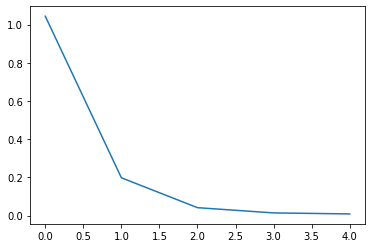

In [262]:
def show_plot(points):
    plt.figure()
    fig, ax = plt.subplots()
    loc = ticker.MultipleLocator(base=0.2) # put ticks at regular intervals
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

show_plot(plot_losses)

In [263]:
evaluate(encoder, decoder, "CCCO")

'CCCCN1CC(=O)O'

In [264]:
quality(encoder,decoder, 50)

predicted canonical SMILES Cc1ncc([N+](=O)[O-])n1CCO n:  0
predicted canonical SMILES O=C(O)CCCCCCCC(=O)O n:  1
predicted canonical SMILES OCCO n:  2
predicted canonical SMILES CC(C)Nc1ncccn1 n:  3
predicted canonical SMILES C=CCOc1ccc(CC(=O)O)cc1Cl n:  4
predicted canonical SMILES NC1=NC(=O)C(c2ccccc2)O1 n:  5
predicted canonical SMILES CC(N)Cc1ccccc1 n:  6
predicted canonical SMILES NCC1CCC(C(=O)O)CC1 n:  7
predicted canonical SMILES S=C=Nc1cccc2ccccc12 n:  8
predicted canonical SMILES NCC(O)c1ccc(O)c(O)c1 n:  9
predicted canonical SMILES NC(C)C(=O)[O-] n:  10
predicted canonical SMILES NCCc1ccc(S(N)(=O)=O)cc1 n:  11
predicted canonical SMILES Nc1ccc(C(=O)O)cc1 n:  12
predicted canonical SMILES FCOC(C(F)(F)F)C(F)(F)F n:  13
predicted canonical SMILES OC1C(O)C(O)C(O)C(O)C1O n:  14
predicted canonical SMILES CCOc1ccc(NC(C)=O)cc1 n:  15
predicted canonical SMILES COc1ccc(NC(C)=O)cc1 n:  16
predicted canonical SMILES FC(F)OC(Cl)C(F)(F)F n:  17
predicted canonical SMILES CCc1cc(C(N)=S)ccn

RDKit ERROR: [23:15:53] SMILES Parse Error: unclosed ring for input: 'CC(O)C(O)C(O)C1O'


predicted canonical SMILES O=c1[nH]ccn1C(N)=O n:  32
predicted canonical SMILES c1ccc2c(CC3=NCCN3)cccc2c1 n:  33
predicted canonical SMILES NCC(O)c1ccc(O)c(O)c1 n:  34
predicted canonical SMILES O=S(=O)(O)CCS n:  35
predicted canonical SMILES OCCN1CC(O)C(O)C(O)C1CO n:  36
predicted canonical SMILES CC(C)Cc1ccc(CC(=O)O)cc1 n:  37
predicted canonical SMILES CCCC(CCC)C(=O)O n:  38
predicted canonical SMILES CCN(CC)C(=O)c1ccccc1 n:  39
predicted canonical SMILES N=C(N)NCCN1CCCCCCC1 n:  41
predicted canonical SMILES c1ccc2c(CC3=NCCN3)cccc2c1 n:  43
predicted canonical SMILES NCC(N)Cc1cccc(C(=O)O)c1 n:  44
predicted canonical SMILES COC(F)(F)C(Cl)Cl n:  46
predicted canonical SMILES C[N+](C)(C)CC(=O)[O-] n:  47
predicted canonical SMILES CCC(CO)NCCNC(CC)CO n:  48
predicted canonical SMILES Nc1nc(=S)c2[nH]cnc2[nH]1 n:  49
Fraction of valid SMILES is:  0.92


RDKit ERROR: [23:15:54] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [23:15:54] SMILES Parse Error: unclosed ring for input: 'CC(O)C(O)C(O)C1O'
RDKit ERROR: [23:15:54] SMILES Parse Error: unclosed ring for input: 'C(=O)NC(=O)NC1=O'


In [287]:
def pics(encoder,decoder,n=10):
    ms = []
    for i in range(n):
        pair = random.choice(pairs)
        output_smiles = evaluate(encoder, decoder, pair[0])
        if validSMILES(output_smiles):
            ms.append(Chem.MolFromSmiles(output_smiles))
            print('predicted canonical SMILES', output_smiles, 'n: ',i)
    return ms
    

predicted canonical SMILES FC(F)OC(F)(F)C(F)Cl n:  0
predicted canonical SMILES N=C(N)NCCCC(N)C(=O)O n:  1
predicted canonical SMILES CCCc1cc(=O)[nH]c(=S)[nH]1 n:  3
predicted canonical SMILES NC(Cc1ccc(O)c(O)c1)C(=O)O n:  4
predicted canonical SMILES O=P1(N(CCCl)CCCl)NCCCO1 n:  5
predicted canonical SMILES O=C(O)O n:  6
predicted canonical SMILES CC(N)Cc1ccccc1 n:  7
predicted canonical SMILES Nc1ccc(C(=O)O)c(O)c1 n:  8
predicted canonical SMILES CC(N)Cc1ccccc1 n:  9


RDKit ERROR: [23:27:10] SMILES Parse Error: unclosed ring for input: 'NCC1CC(C(=O)O)c1cccnc1'


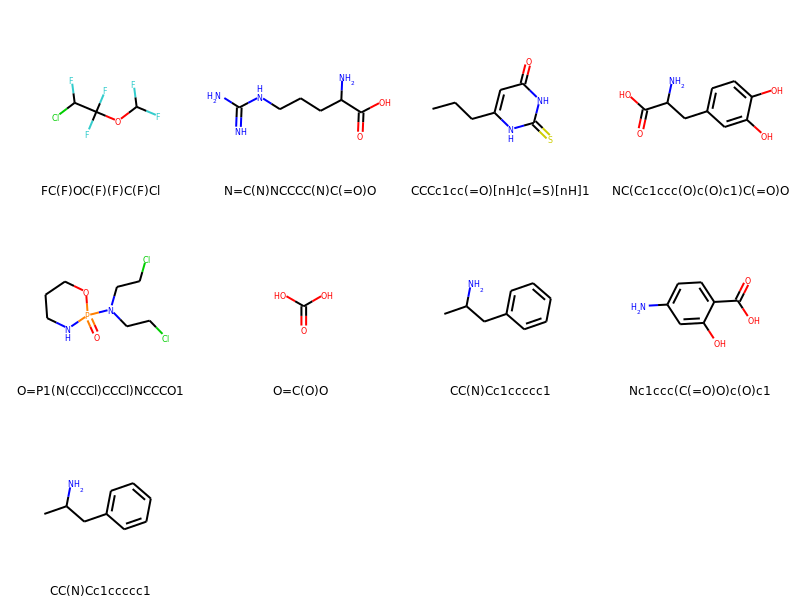

In [288]:
ms = pics(encoder,decoder)
Draw.MolsToGridImage(ms,molsPerRow=4,subImgSize=(200,200),legends=[Chem.MolToSmiles(x) for x in ms])

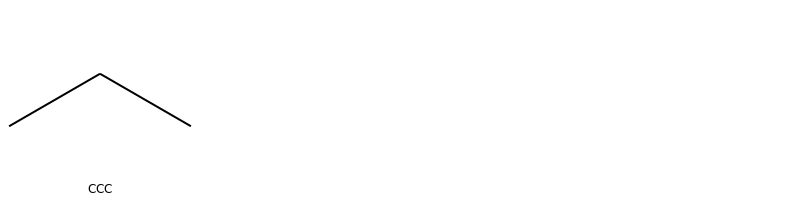

In [284]:
ms= [Chem.MolFromSmiles('CCC')]
Draw.MolsToGridImage(ms,molsPerRow=4,subImgSize=(200,200),legends=[Chem.MolToSmiles(x) for x in ms])

In [285]:
ms

0m 15s (- 4m 51s) (50 5%) 3.7732
0m 30s (- 4m 31s) (100 10%) 4.2031
0m 46s (- 4m 22s) (150 15%) 5.4111
1m 0s (- 4m 2s) (200 20%) 2.5326
1m 14s (- 3m 42s) (250 25%) 2.1887
1m 30s (- 3m 30s) (300 30%) 2.2339
1m 47s (- 3m 19s) (350 35%) 1.9548
2m 2s (- 3m 4s) (400 40%) 1.9077
2m 18s (- 2m 49s) (450 45%) 1.7853
2m 36s (- 2m 36s) (500 50%) 2.0057
2m 50s (- 2m 19s) (550 55%) 1.8321
3m 3s (- 2m 2s) (600 60%) 1.6831
3m 18s (- 1m 46s) (650 65%) 1.6905
3m 33s (- 1m 31s) (700 70%) 1.7059
3m 48s (- 1m 16s) (750 75%) 1.7167
4m 2s (- 1m 0s) (800 80%) 1.7275
4m 18s (- 0m 45s) (850 85%) 1.5289
4m 33s (- 0m 30s) (900 90%) 1.7386
4m 48s (- 0m 15s) (950 95%) 1.9763
5m 2s (- 0m 0s) (1000 100%) 1.8370
Model was saved as  SMILESencoder512.pt and SMILESdecoder512.pt


<Figure size 432x288 with 0 Axes>

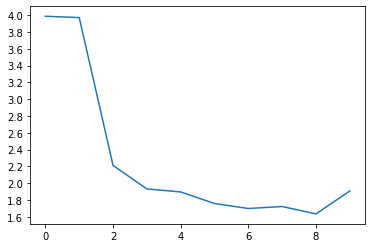

In [53]:
torch.save(encoder.state_dict(), savedencoderfile)
torch.save(decoder.state_dict(), saveddecoderfile)
print("Model was saved as ",savedencoderfile, "and", saveddecoderfile )

In [201]:
evaluateRandomly(encoder, decoder)

original smiles CCc1cc(C(N)=S)ccn1
actual canonical SMILES CCc1cc(C(N)=S)ccn1
predicted canonical SMILES CCc1ccc(CC(=O)NC(C)Cc1ccc

original smiles C1N2CN3CN1CN(C2)C3
actual canonical SMILES C1N2CN3CN1CN(C2)C3
predicted canonical SMILES Clc1ccccc12<EOS>

original smiles CC(C)Cc1ccc(CC(=O)O)cc1
actual canonical SMILES CC(C)Cc1ccc(CC(=O)O)cc1
predicted canonical SMILES CC(C)Cc1ccccc1<EOS>

original smiles Nc1ccc(C(=O)O)cc1
actual canonical SMILES Nc1ccc(C(=O)O)cc1
predicted canonical SMILES Nc1ccc(OC(F)(F)F)cc2s1<EOS>

original smiles CC1=CC(=O)c2ccccc2C1=O
actual canonical SMILES CC1=CC(=O)c2ccccc2C1=O
predicted canonical SMILES CC1=CC(=O)cc1<EOS>



# Saving the model

In [133]:
torch.save(encoder1.state_dict(), savedencoderfile)
torch.save(decoder1.state_dict(), saveddecoderfile)
print("Model was saved as ",savedencoderfile, "and", saveddecoderfile )

Model was saved as  SMILESencoder.pt and SMILESdecoder.pt


https://github.com/spro/practical-pytorch/blob/master/seq2seq-translation/seq2seq-translation-batched.ipynb

In [ ]:

#################################
class Model_RNN(nn.Module):
    def __init__(self):
        super(Model_RNN, self).__init__()
        self.rnn = nn.RNN(
                input_size = input_size,
                hidden_size = hidden_size,
                num_layers = num_layers,
                batch_first = True)
        self.Rnn_type = 'RNN'

    def forward(self, x, hidden):
        # Reshape input in (bs, seqlen, inpsz)
        x = x.view(batch_size, seq_len, input_size)

        # Propagete inp thru RNN
        #   Input: (batchsz, seq_len, inpsz)
        out, hidden = self.rnn(x, hidden)

        # Output: (batchsz, seq_len, hiddensz)
        out = out.view(-1, num_classes)
        return hidden, out

    def init_hidden(self):
        # Init hidden and cell states
        # (num_layers * num_dir, batch, hidden_sz)
        return Variable(torch.zeros(num_layers, batch_size, hidden_size))

class Model_LSTM(nn.Module):
    def __init__(self):
        super(Model_LSTM, self).__init__()
        self.rnn = nn.LSTM(
                input_size = input_size,
                hidden_size = hidden_size,
                num_layers = num_layers,
                batch_first = True)
        self.Rnn_type = 'LSTM'

    def forward(self, x, hidden):
        # Reshape input in (bs, seqlen, inpsz)
        x = x.view(batch_size, seq_len, input_size)

        # Propagete inp thru RNN
        #   Input: (batchsz, seq_len, inpsz)
        out, hidden = self.rnn(x, hidden)

        # Output: (batchsz, seq_len, hiddensz)
        out = out.view(-1, num_classes)
        return hidden, out

    def init_hidden(self):
        # Init hidden and cell states
        # (num_layers * num_dir, batch, hidden_sz)
        # LSTM hidden state is a tuple (h_0, c_0)
        h_0 = Variable(torch.zeros(num_layers, batch_size, hidden_size))
        c_0 = Variable(torch.zeros(num_layers, batch_size, hidden_size))
        hidden = (h_0, c_0)
        return hidden

#################################

Inp_size = len(Inp_alphabet)
Out_size = len(Out_alphabet)
torch.manual_seed(2.7321)

#################################
num_classes = Out_size          #  XXX why need a separate num_classes,  when hidden_size would do?
input_size = Inp_size  # this parameter is for the view function to know how large
#the one hot vector is supposed to be

hidden_size = Out_size #
batch_size = 1   # id dont understand this
seq_len = Seq_max
num_layers = Arg_num_layers  # num-layers of rnn
#learning_rate = 0.01
momentum = 0.1


############## Model Training code ##########################
def train_phase():
    global Optimizer
    MIN_LOSS = float('inf')
    MIN_LOSS_epoch_counter = 0
    MAX_ACC_epoch_counter = 0

    final_train_epoch=0
    final_train_accuracy=0

    for epoch in range(max_epochs):
        Optimizer.zero_grad()
        loss = 0
        errcount = 0
        # if epoch % 30 ==0:
        #     evaluate_model(inputs,labels)
        for input, label in zip(Inputs, Labels):
            # input = input.unsqueeze(0)
            hidden = model.init_hidden() #we reset the RNN to its initial state
            hidden, output = model(input, hidden) #run the model

            val, idx = output.max(1)
            expected = decode_out(label)
            trained = decode_out(idx)

            if trained != expected:
                errcount += 1

            if epoch % vizdelay == 0:
                if (trained != expected):
                    print("check : ", decode_inp(input), " -> expected: ", expected, "        predicted: ", trained, "   *****")
                else:
                    print("check : ", decode_inp(input), " -> expected: ", expected, "        predicted: ", trained)
            loss += Criterion(output, label) #add the current sample error to loss

        loss.backward()
        Optimizer.step()

        ########### Within loop plotting and logging ########
        if loss.data < MIN_LOSS:
            MIN_LOSS = loss.data
            MIN_LOSS_epoch_counter = epoch   # reset

        accuracy = 100.0 * (Num_io_data - errcount) / Num_io_data
        print("Epoch: %d, loss: %1.3f         errcount: %d  accuracy: %1.1f%%\n" % (epoch+1, loss.data, errcount, accuracy))
        print("-------------------------------------------")

        plot_data.append([loss.data.item(), accuracy])
        t = [ x for x in range(0, epoch)]
        p = np.array(plot_data)
        plt_ax1.plot(p[:, 0], color='red')
        plt_ax2.plot(p[:, 1], color='blue')
        plt.pause(0.001)
        #plt.show()

        final_train_epoch = epoch
        final_train_accuracy = accuracy
        if BREAK_EARLY == True:
            global Train_end_reason
            if (epoch - MIN_LOSS_epoch_counter) >= 20:
                Train_end_reason = "=== no new low of training_loss seen for last 20 epochs; stop training"
                print(Train_end_reason)
                break

            if accuracy >= 99.9:
                MAX_ACC_epoch_counter += 1
                # stop, if accuracy stays at ~100 for 10 epochs
                if MAX_ACC_epoch_counter >= 10:
                    Train_end_reason = "=== maximal accuracy seen for last 10 epochs; stop training"
                    print(Train_end_reason)
                    time.sleep(4)
                    break

        # update optimizer with changed lr - depending on accuracy
        Optimizer = get_new_optimizer(learning_rate, accuracy)
    return final_train_accuracy, final_train_epoch


####################### Model evaluation code ################
def evaluate_model_1(xdata, ydata):
    x_one_hot = simple_to_onehot(xdata, Inp_alphabet)
    inputs = Variable(torch.Tensor(x_one_hot))
    labels = Variable(torch.LongTensor(ydata))

    err_count = 0
    for input, label in zip(inputs, labels):
        expected = decode_out(label)
        hidden = model.init_hidden()
        hidden, output = model(input, hidden)
        val, idx = output.max(1)
        predicted = decode_out(idx)
        if (expected != predicted):
            print("check : ", decode_inp(input), " -> expected: ", expected, "        predicted: ", predicted, "   *****")
            err_count += 1
        else:
            print("check : ", decode_inp(input), " -> expected: ", expected, "        predicted: ", predicted)
    return (err_count)

def evaluate_model(xdata, ydata, seqmax):
    xdata = simple_encode_strlist(xdata, seqmax, Inp_alphabet)
    ydata = simple_encode_strlist(ydata, seqmax, Out_alphabet)
    return evaluate_model_1(xdata, ydata)

################################################################################
def validation_phase():
    print("============================= validation inputs ===========================")
    validation_inputs, validation_outputs, seqmax = load_data_file('rnn3-train-data.txt')
    num_io_data = len(validation_inputs)
    if seqmax != Seq_max:
        print("seqmax mismatch", seqmax, Seq_max)
        sys.exit(1)
    seqmax = Seq_max

    errcount = evaluate_model(validation_inputs, validation_outputs, seqmax)
    val_accuracy = 100.0 * (num_io_data - errcount) / num_io_data

    if errcount > 0:
        print("VALIDATION FAILED:  errors: ", errcount, "accuracy:", val_accuracy)
    else:
        print("Validation Passed")
    return val_accuracy


################################################################################
def test_phase():
    print("============================= test inputs ===========================")
    test_inputs, test_outputs, seqmax = load_data_file('rnn3-test-data.txt')
    num_io_data = len(test_inputs)
    #if seqmax != Seq_max: #this could happen just due to randomness #todo
    #    print("WARN: seqmax mismatch")     ## possible to have diff seq max from the train data
    #    sys.exit(1)
    seqmax = Seq_max


    errcount = evaluate_model(test_inputs, test_outputs, seqmax)
    test_accuracy = 100.0 * (num_io_data - errcount) / num_io_data

    print("Testset size: ", len(test_inputs),"Test errors: ", errcount, "accuracy:", test_accuracy)
    return test_accuracy

################################################################################

########################################################
#Instantiate RNN model
#model = Model_RNN()
Rnn_type = '###'
model = Model_LSTM()
Rnn_type = model.Rnn_type

####################### Plotting code ##################

plt.ion()
plt_fig, plt_ax1 = plt.subplots()
plt_ax2 = plt_ax1.twinx()
plt_ax1.set_xlabel('epoch')
plt_ax1.set_ylabel('loss', color='red')
plt_ax2.set_ylabel('accuracy', color='blue')

txt = "Dataset: " + Arg_dataset_name + "\nrnn_type: "+ Rnn_type + "\nnum_layers: "+ str(num_layers) + "\nnum_io_samples: "+ str(Num_io_data) + "\nseq_max_len: "+ str(Seq_max)
txt += "\nBase_LR: " + str(learning_rate)

#plt_fig = plt.figure()
plt_fig.text(.5, .2, txt, ha='center', transform=plt_ax1.transAxes)
plt.pause(0.001)

plot_data = []
########################################################



################## Load trained model ###############
from pathlib import Path
modelimagefile = "rnn3model." + Imagesuffix + ".pt"
if Path(modelimagefile).is_file():
    # file exists
    model.load_state_dict(torch.load(modelimagefile))
    model.eval()
    print("=== Model was loaded from " + modelimagefile)

####################################################
Criterion = torch.nn.CrossEntropyLoss()
Optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
####################################################



# X is OH encoded
# Y is simple encoded
# this is the format needed by pytorch
Inputs = Variable(torch.Tensor(X_ohe))
Labels = Variable(torch.LongTensor(Y_data))

print("Input shape: ", Inputs.size())
print("Output shape: ", Labels.size())

final_train_accuracy, final_train_epoch = train_phase()

############ final plotting and logging ################
#plt.plot(plot_data)
#plt.waitforbuttonpress()
plt.savefig('rnn3-ttt.png',  bbox_inches='tight')
plt.show()
########################################################

val_accuracy = validation_phase()
test_accuracy = test_phase()

print("---------------------------------------------------------------------")
print("=== rnn_type:", Rnn_type,
        "num_layers:", num_layers,
        "num_io_samples (train): ", Num_io_data,
        "seq_max_len:", Seq_max)

print("\n Training end due to: ", Train_end_reason)
print("\n=== final_train_epoch:", final_train_epoch)
print("=== final_train_accuracy:  %1.2f%%       \n=== val_accuracy:  %1.2f%%        \n=== test_accuracy:  %1.2f%%\n"
        %  (final_train_accuracy, val_accuracy, test_accuracy))


######################### save trained model #######################
torch.save(model.state_dict(), modelimagefile)
print("=== Model was saved as " + modelimagefile)
####################################################################

In [36]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=1)
print("Train proportion: ",len(Xtrain)/len(X))

Train proportion:  0.7494824016563147


In [37]:
skmodel = LogisticRegression(class_weight='balanced')
#skmodel = LogisticRegression()
#skmodel = GaussianNB()
skmodel.fit(Xtrain, ytrain)                  
y_model = skmodel.predict(Xtest)   
ytrain_model = skmodel.predict(Xtrain)
print('Train accuracy: ',accuracy_score(ytrain, ytrain_model))
print('Test accuracy: ',accuracy_score(ytest, y_model))
print('F1 score: ',f1_score(ytest, y_model))
print('Matthews correlation coefficient: ',matthews_corrcoef(ytest,y_model))

Train accuracy:  0.9378453038674033
Test accuracy:  0.6074380165289256
F1 score:  0.6215139442231075
Matthews correlation coefficient:  0.21430796208172556


Basic Logistic regression
Train accuracy:  0.9972375690607734
Test accuracy:  0.5867768595041323
F1 score:  0.5934959349593496
Matthews correlation coefficient:  0.17332786773245884

In [38]:
Xtrain.shape

(724, 512)

In [44]:
input_size = 512
output_size = 1
hidden_sizes = [128, 64]
model = nn.Sequential(nn.Linear(input_size, hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.Sigmoid())
print(model)
criterion = nn.MSELoss()

#CrossEntropyLoss() requires logits as the output and class labels as the target

Sequential(
  (0): Linear(in_features=512, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=1, bias=True)
  (3): Sigmoid()
)


In [48]:
X = torch.from_numpy(X).float()
y = torch.from_numpy(y).float()
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=1)
print("Xtrain.shape: ",Xtrain.shape)

Xtrain.shape:  torch.Size([724, 512])


In [56]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01) #weight_decay=1e-5
epochs = 10
for e in range(epochs):
    output = model(Xtrain)
    labels = ytrain.unsqueeze(1)
    optimizer.zero_grad()
    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()
    if e % 2 == 0:
        print("Training loss: ",loss.item())

Training loss:  0.0852215439081192
Training loss:  0.07720500975847244
Training loss:  0.08967221528291702
Training loss:  0.10272926092147827
Training loss:  0.07113324850797653


In [57]:
predictions = output.detach().numpy()
predictions = np.where(predictions > 0.5, 1, 0)
predictions.sum()

354

In [58]:
testoutput = model(Xtest)
testpredictions = testoutput.detach().numpy()
testpredictions = np.where(testpredictions > 0.5, 1, 0)
testpredictions.sum()

100

In [59]:
print('Train accuracy: ',accuracy_score(predictions,ytrain))
print('Test accuracy: ',accuracy_score(testpredictions, ytest))
print('F1 score: ',f1_score(testpredictions, ytest))
print('Matthews: ',matthews_corrcoef(testpredictions, ytest))

Train accuracy:  0.9406077348066298
Test accuracy:  0.5661157024793388
F1 score:  0.5291479820627804
Matthews:  0.13720062149495627


In [ ]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image


parser = argparse.ArgumentParser(description='VAE MNIST Example')
parser.add_argument('--batch-size', type=int, default=128, metavar='N',
                    help='input batch size for training (default: 128)')
parser.add_argument('--epochs', type=int, default=10, metavar='N',
                    help='number of epochs to train (default: 10)')
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='disables CUDA training')
parser.add_argument('--seed', type=int, default=1, metavar='S',
                    help='random seed (default: 1)')
parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                    help='how many batches to wait before logging training status')
args = parser.parse_args()
args.cuda = not args.no_cuda and torch.cuda.is_available()

torch.manual_seed(args.seed)

device = torch.device("cuda" if args.cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if args.cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=args.batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.ToTensor()),
    batch_size=args.batch_size, shuffle=True, **kwargs)


class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 20)
        self.fc22 = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)


# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD


def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))


def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                      recon_batch.view(args.batch_size, 1, 28, 28)[:n]])
                save_image(comparison.cpu(),
                         'results/reconstruction_' + str(epoch) + '.png', nrow=n)

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

if __name__ == "__main__":
    for epoch in range(1, args.epochs + 1):
        train(epoch)
        test(epoch)
        with torch.no_grad():
            sample = torch.randn(64, 20).to(device)
            sample = model.decode(sample).cpu()
            save_image(sample.view(64, 1, 28, 28),
                       'results/sample_' + str(epoch) + '.png')

In [2]:
print("hello")

hello
